Kích thước dữ liệu tổng hợp: (1220, 12)


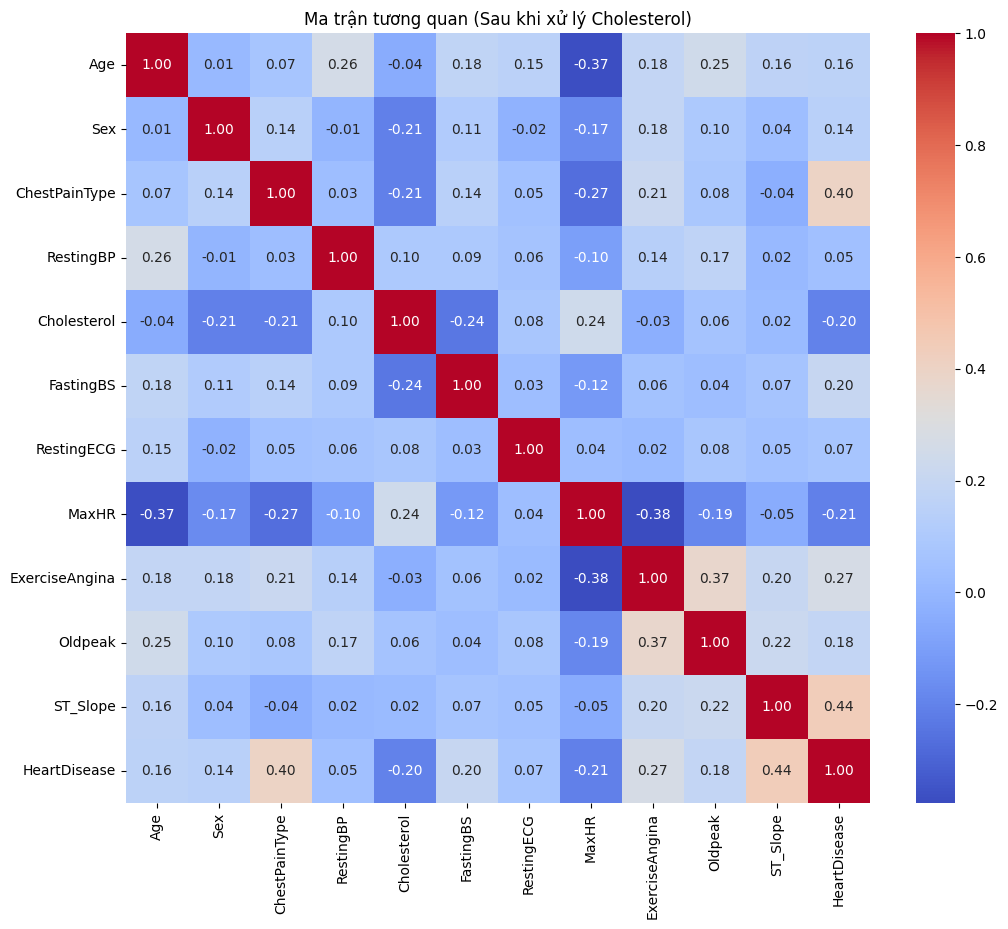

In [294]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- BƯỚC 1: ĐỌC VÀ ĐỒNG BỘ DỮ LIỆU ---
data1 = pd.read_csv('heart.csv')  # Dữ liệu chữ
data2 = pd.read_csv('heart2.csv') # Dữ liệu số

# Từ điển ánh xạ để chuyển chữ sang số
mapping_config = {
    'ChestPainType': {'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3},
    'RestingECG':    {'Normal': 0, 'ST': 1, 'LVH': 2},
    'ExerciseAngina':{'Y': 1, 'N': 0},
    'ST_Slope':      {'Up': 0, 'Flat': 1, 'Down': 2},
    'Sex':           {'M': 1, 'F': 0}
}

df1_clean = data1.copy()
for col, mapping in mapping_config.items():
    df1_clean[col] = df1_clean[col].map(mapping)

df1_clean = df1_clean.fillna(0) # Xử lý lỗi nếu có

# Gộp dữ liệu
df_final = pd.concat([df1_clean, data2], ignore_index=True)

#Loại bỏ duplicate rows if any
df_final = df_final.drop_duplicates()
print(f"Kích thước dữ liệu tổng hợp: {df_final.shape}")

# --- BƯỚC 3: TRỰC QUAN HÓA TƯƠNG QUAN ---
plt.figure(figsize=(12, 10))
sns.heatmap(df_final.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan (Sau khi xử lý Cholesterol)")
plt.show()

=== KẾT QUẢ MÔ HÌNH CƠ SỞ (Ngưỡng 0.5) ===
Độ chính xác (Accuracy): 79.92%
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       103
           1       0.83      0.82      0.83       141

    accuracy                           0.80       244
   macro avg       0.79      0.79      0.79       244
weighted avg       0.80      0.80      0.80       244



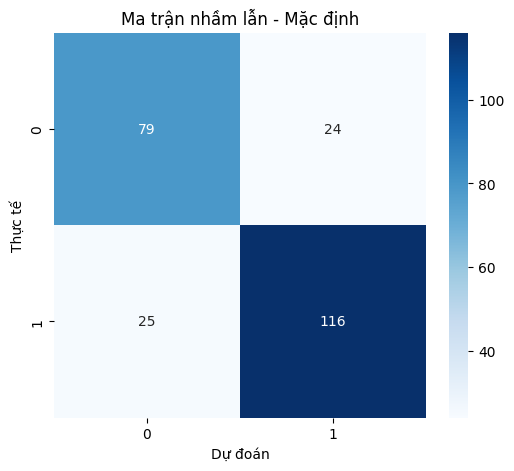

In [295]:
# --- BƯỚC 4: CHUẨN BỊ DỮ LIỆU HUẤN LUYỆN ---
X = df_final.drop('HeartDisease', axis=1)
y = df_final['HeartDisease']

# Chia tập dữ liệu 80% Train - 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu (Standard Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- BƯỚC 5: HUẤN LUYỆN LOGISTIC REGRESSION ---
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# --- BƯỚC 6: ĐÁNH GIÁ MẶC ĐỊNH (Ngưỡng 0.5) ---
y_pred = model.predict(X_test_scaled)

print("=== KẾT QUẢ MÔ HÌNH CƠ SỞ (Ngưỡng 0.5) ===")
print(f"Độ chính xác (Accuracy): {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(classification_report(y_test, y_pred))

# Vẽ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Ma trận nhầm lẫn - Mặc định')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()


=== KẾT QUẢ TỐI ƯU (Ngưỡng 0.3) ===
              precision    recall  f1-score   support

           0       0.86      0.63      0.73       103
           1       0.77      0.92      0.84       141

    accuracy                           0.80       244
   macro avg       0.81      0.78      0.78       244
weighted avg       0.81      0.80      0.79       244



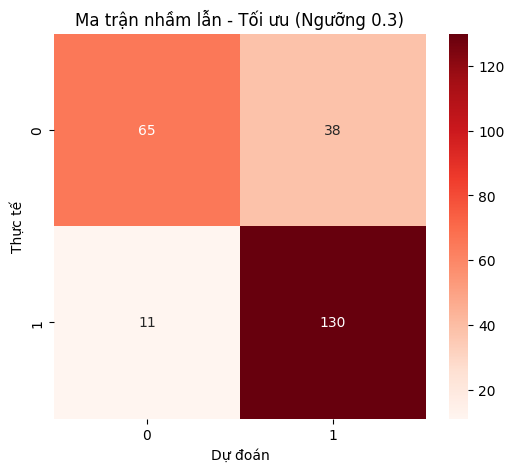

In [296]:
# --- BƯỚC 7: TỐI ƯU HÓA NGƯỠNG (THRESHOLD TUNING) ---

# Lấy xác suất dự đoán thay vì nhãn 0/1
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Đặt ngưỡng mới an toàn hơn (0.3)
new_threshold = 0.3
y_pred_new = (y_prob >= new_threshold).astype(int)

print(f"\n=== KẾT QUẢ TỐI ƯU (Ngưỡng {new_threshold}) ===")
print(classification_report(y_test, y_pred_new))

# Vẽ Confusion Matrix so sánh
plt.figure(figsize=(6, 5))
cm_new = confusion_matrix(y_test, y_pred_new)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Reds')
plt.title(f'Ma trận nhầm lẫn - Tối ưu (Ngưỡng {new_threshold})')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()


=== HUẤN LUYỆN LẠI VỚI TRỌNG SỐ {0: 1, 1: 3} ===
Báo cáo chi tiết (Class Weight Model):
              precision    recall  f1-score   support

           0       0.88      0.57      0.69       103
           1       0.75      0.94      0.84       141

    accuracy                           0.79       244
   macro avg       0.82      0.76      0.77       244
weighted avg       0.81      0.79      0.78       244



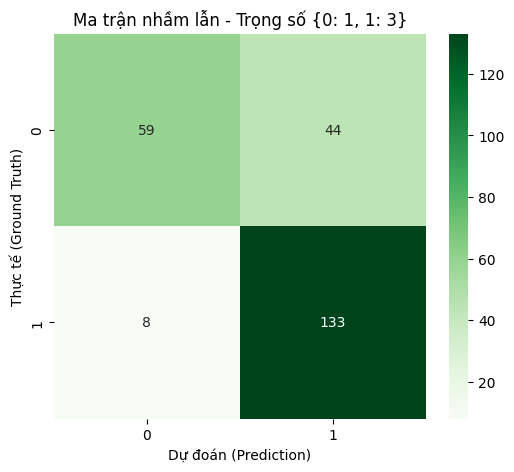

In [ ]:
# --- BƯỚC 8: CÁCH 2 - SỬ DỤNG TRỌNG SỐ LỚP (CLASS WEIGHT) ---
# Mục tiêu: Ép mô hình coi trọng người bệnh (nhãn 1) hơn người khỏe (nhãn 0) ngay khi học.

# Định nghĩa trọng số: {0: 1, 1: 3}
# Ý nghĩa: Bỏ sót 1 người bệnh (False Negative) bị phạt nặng bằng đoán sai 3 người khỏe.
# Bạn có thể thử thay số 3 bằng 2, 4, 5 để xem Recall thay đổi thế nào.
custom_weights = {0: 1, 1: 2}

print(f"\n=== HUẤN LUYỆN LẠI VỚI TRỌNG SỐ {custom_weights} ===")

# 1. Khởi tạo mô hình MỚI với tham số class_weight
# Lưu ý: Phải train lại từ đầu
model_weighted = LogisticRegression(class_weight=custom_weights, random_state=42)

# 2. Huấn luyện lại
model_weighted.fit(X_train_scaled, y_train)

# 3. Dự đoán
# Lưu ý: Với cách này, ta dùng ngưỡng mặc định 0.5 là đã tốt rồi,
# vì sự thiên vị đã được tích hợp vào công thức toán học bên trong.
y_pred_weighted = model_weighted.predict(X_test_scaled)

# 4. In báo cáo
print("Báo cáo chi tiết (Class Weight Model):")
print(classification_report(y_test, y_pred_weighted))

# 5. Vẽ Confusion Matrix so sánh
plt.figure(figsize=(6, 5))
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
# Dùng màu Xanh Lá (Greens) để phân biệt với 2 cách trước
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Greens')
plt.title(f'Ma trận nhầm lẫn - Trọng số {custom_weights}')
plt.ylabel('Thực tế (Ground Truth)')
plt.xlabel('Dự đoán (Prediction)')
plt.show()


=== KẾT QUẢ KẾT HỢP: CLASS WEIGHT + THRESHOLD 0.35 ===
              precision    recall  f1-score   support

           0       0.87      0.46      0.60       103
           1       0.71      0.95      0.81       141

    accuracy                           0.74       244
   macro avg       0.79      0.70      0.70       244
weighted avg       0.77      0.74      0.72       244



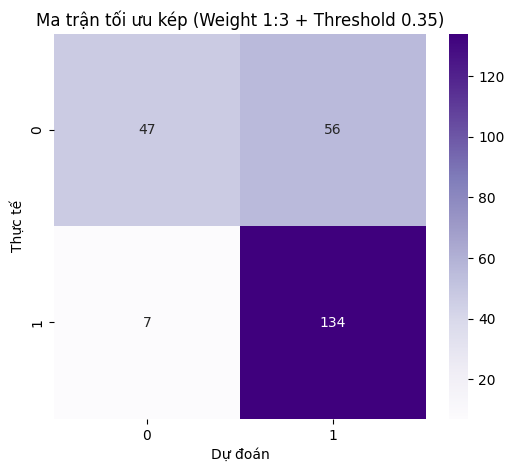

In [298]:
# --- BƯỚC 9: KẾT HỢP CẢ 2 PHƯƠNG PHÁP (ULTIMATE OPTIMIZATION) ---
# Chiến lược:
# 1. Train model với trọng số {0: 1, 1: 3} để AI học cách sợ bỏ sót bệnh.
# 2. Sau đó tiếp tục hạ ngưỡng xuống 0.35 để rà soát kỹ lần cuối.

print(f"\n=== KẾT QUẢ KẾT HỢP: CLASS WEIGHT + THRESHOLD 0.35 ===")

# 1. Lấy xác suất từ mô hình đã gán trọng số (model_weighted ở Bước 8)
# Lưu ý: model_weighted đã được train với class_weight={0:1, 1:3}
y_prob_weighted = model_weighted.predict_proba(X_test_scaled)[:, 1]

# 2. Áp dụng ngưỡng mới trên mô hình này
final_threshold = 0.35
y_pred_combined = (y_prob_weighted >= final_threshold).astype(int)

# 3. Đánh giá độ hiệu quả
print(classification_report(y_test, y_pred_combined))

# 4. Vẽ Confusion Matrix cuối cùng
plt.figure(figsize=(6, 5))
cm_combined = confusion_matrix(y_test, y_pred_combined)
# Dùng màu Tím (Purples) cho phiên bản mạnh nhất
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Purples')
plt.title(f'Ma trận tối ưu kép (Weight 1:3 + Threshold {final_threshold})')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

Đang chạy Grid Search để tìm tham số tối ưu...

--- KẾT QUẢ TỐI ƯU ---
Tham số tốt nhất tìm được: {'C': 0.01, 'class_weight': {0: 1, 1: 3}, 'solver': 'lbfgs'}
Điểm Recall tốt nhất trên tập Train: 0.97

Báo cáo trên tập Test (Model đã tối ưu):
              precision    recall  f1-score   support

           0       0.87      0.47      0.61       103
           1       0.71      0.95      0.81       141

    accuracy                           0.75       244
   macro avg       0.79      0.71      0.71       244
weighted avg       0.78      0.75      0.73       244



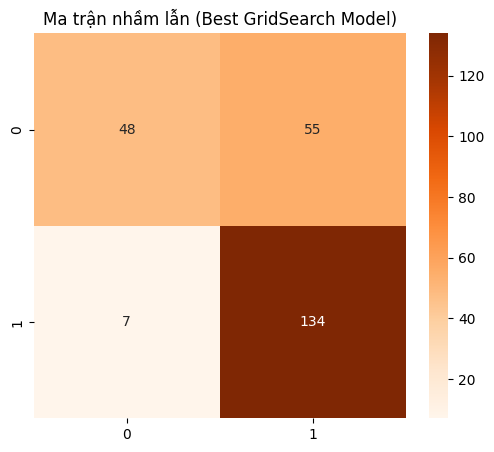

In [299]:
from sklearn.model_selection import GridSearchCV

# --- BƯỚC 5 (NÂNG CẤP): TÌM MODEL TỐT NHẤT BẰNG GRID SEARCH ---

# 1. Định nghĩa "lưới" các tham số muốn thử
# Máy sẽ thử tổ hợp: C=0.1 + liblinear, C=0.1 + lbfgs, C=1 + liblinear... v.v.
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Thử độ mạnh yếu của Regularization
    'solver': ['liblinear', 'lbfgs'], # Thử các bộ giải toán học khác nhau
    'class_weight': [None, 'balanced', {0:1, 1:3}] # Kết hợp luôn cả trọng số lớp
}

print("Đang chạy Grid Search để tìm tham số tối ưu...")

# 2. Khởi tạo GridSearch
# cv=5 nghĩa là Cross-Validation 5 lần (chia dữ liệu làm 5 phần để kiểm tra chéo) - Rất uy tín
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                           param_grid, 
                           cv=5, 
                           scoring='recall') # Ưu tiên tìm model có Recall cao nhất (tránh bỏ sót bệnh)

# 3. Huấn luyện (Máy sẽ chạy rất nhiều model ngầm bên dưới)
grid_search.fit(X_train_scaled, y_train)

# 4. Lấy ra model tốt nhất
best_model = grid_search.best_estimator_

print("\n--- KẾT QUẢ TỐI ƯU ---")
print(f"Tham số tốt nhất tìm được: {grid_search.best_params_}")
print(f"Điểm Recall tốt nhất trên tập Train: {grid_search.best_score_:.2f}")

# --- BƯỚC 6: DỰ ĐOÁN BẰNG MODEL TỐT NHẤT ---
# Lưu ý: Lúc này dùng best_model để dự đoán
y_pred_optimized = best_model.predict(X_test_scaled)

print("\nBáo cáo trên tập Test (Model đã tối ưu):")
print(classification_report(y_test, y_pred_optimized))

# Vẽ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_optimized), annot=True, fmt='d', cmap='Oranges')
plt.title('Ma trận nhầm lẫn (Best GridSearch Model)')
plt.show()